# 🌾 Crop Yield Prediction using Machine Learning Pipelines  

In this project, I built a **Crop Yield Prediction Model** to estimate agricultural yield (tons/hectare) using environmental, soil, and farming practice data.  
The dataset was carefully explored, cleaned, and preprocessed to ensure no **data leakage** between training and test phases.  
My goal was to evaluate multiple regression algorithms and select the best-performing model for deployment, which turned out to be **XGBoost** after thorough comparison.  

## 📌 Key Steps  

**Dataset Exploration & Cleaning**  
- Loaded `crop_yield.csv` and performed detailed exploratory data analysis (EDA)  
- Visualized correlations, feature distributions, and outliers  
- Detected and treated outliers using the IQR method  
- Handled missing values and removed duplicate records  

**Feature Engineering & Preprocessing**  
- Defined numerical, categorical, and boolean feature groups  
- Applied median imputation + scaling for numerical features  
- Applied most frequent imputation + One-Hot Encoding for categorical features  
- Combined transformations using `ColumnTransformer` within a unified pipeline  

**Model Training & Selection**  
- Compared Linear Regression, Ridge, Lasso, ElasticNet, Random Forest, and XGBoost  
- Evaluated using R², RMSE, MAPE, and training time  
- Selected XGBoost as best model

**Hyperparameter Tuning**  
- Used `GridSearchCV` to optimize parameters such as n_estimators, max_depth, learning_rate, etc.  
- Achieved improved validation performance after tuning  

**Evaluation & Insights**  
- Reported final R² and RMSE on test data  
- Extracted feature importances to identify key factors affecting yield  
- Visualized feature contribution rankings  

**Deployment & Prediction**  
- Saved the trained pipeline using `joblib`  
- Loaded the model to predict yield for new, unseen data  
- Compared actual vs predicted yields on sample test records  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [ ]:
df=pd.read_csv('crop_yield.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [ ]:
df.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


In [ ]:
# Summary statistics (categorical features)
print("\nSummary Statistics (Categorical):")
display(df.describe(include='object').T)


Summary Statistics (Categorical):


,count,unique,top,freq
Region,1000000,4,North,250173
Soil_Type,1000000,6,Sandy,167119
Crop,1000000,6,Maize,166824
Weather_Condition,1000000,3,Sunny,333790


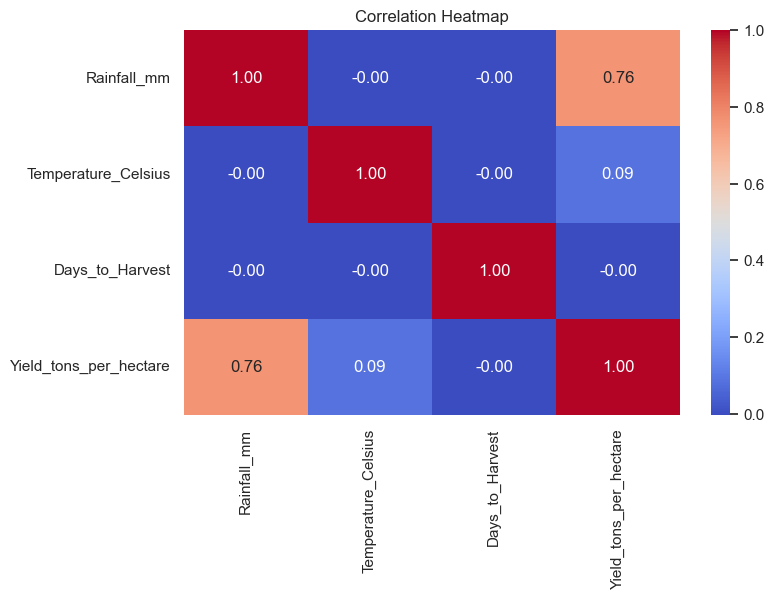

In [ ]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8,5))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Install Sweetviz
!pip install sweetviz --quiet

import sweetviz as sv
report = sv.analyze(df)

# Save and display report
report.show_html("sweetviz_report.html")

print("✅ Sweetviz EDA report generated: sweetviz_report.html")


                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
✅ Sweetviz EDA report generated: sweetviz_report.html


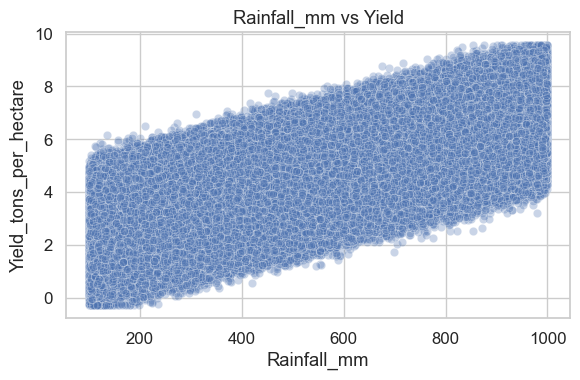

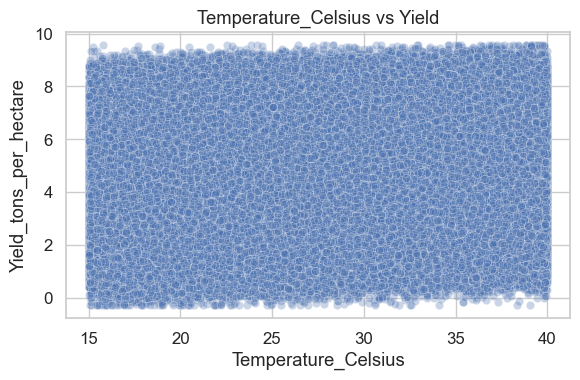

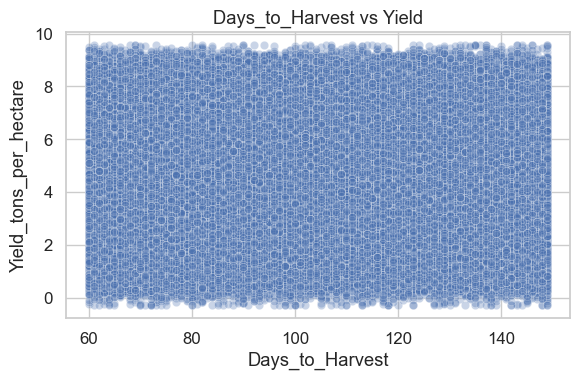

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Identify numeric features (excluding target)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('Yield_tons_per_hectare')

# 1. Scatter plots for all numeric features
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='Yield_tons_per_hectare', alpha=0.3)
    plt.title(f"{col} vs Yield")
    plt.tight_layout()
    plt.show()

In [ ]:
df.isnull().sum()

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

In [ ]:
df.duplicated().sum()


np.int64(0)

In [ ]:
df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [ ]:
df.shape

(1000000, 10)

<Axes: xlabel='Yield_tons_per_hectare', ylabel='Count'>

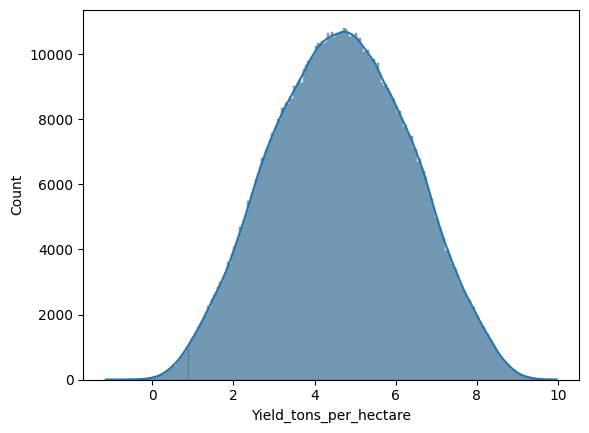

In [ ]:
import seaborn as sns
sns.histplot(df['Yield_tons_per_hectare'], kde=True)


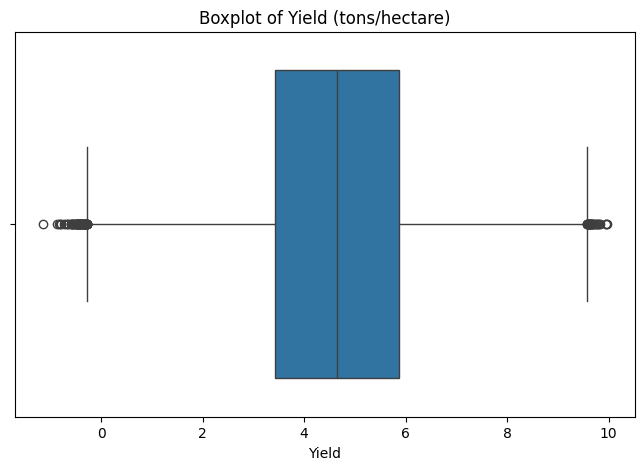

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Yield_tons_per_hectare'])
plt.title('Boxplot of Yield (tons/hectare)')
plt.xlabel('Yield')
plt.show()


In [ ]:
Q1 = df['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR


In [ ]:
df['Yield_tons_per_hectare'] = df['Yield_tons_per_hectare'].where(
    df['Yield_tons_per_hectare'] > lower_limit, lower_limit
)
df['Yield_tons_per_hectare'] = df['Yield_tons_per_hectare'].where(
    df['Yield_tons_per_hectare'] < upper_limit, upper_limit
)

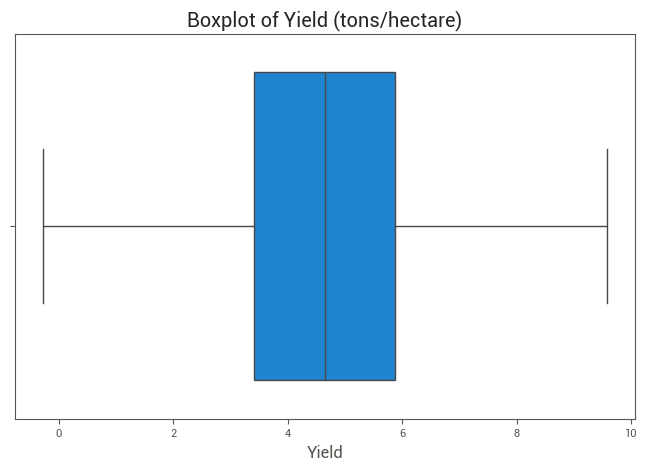

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Yield_tons_per_hectare'])
plt.title('Boxplot of Yield (tons/hectare)')
plt.xlabel('Yield')
plt.show()


In [ ]:
df.shape

(1000000, 10)

In [ ]:
df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [ ]:
df.dtypes

Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object

In [ ]:
# Define column groups
num_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
cat_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
bool_features = ['Fertilizer_Used', 'Irrigation_Used']

In [ ]:
# Column Transformer
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('bool', 'passthrough', bool_features)
])


In [ ]:
# Define models in pipeline
from sklearn.preprocessing import PolynomialFeatures
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(random_state=42),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

In [ ]:
X = df.drop('Yield_tons_per_hectare', axis=1)
y = df['Yield_tons_per_hectare']


In [ ]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import time
import pandas as pd
import numpy as np

results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    start_time = time.time()
    pipe.fit(X_train, y_train)  # Train the model
    total_time = time.time() - start_time

    # Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # R² scores
    r2_train = pipe.score(X_train, y_train)
    r2_test = pipe.score(X_test, y_test)

    # RMSE & MAPE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    results.append({
        'Model': name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Train Time (s)': total_time
    })

# Results table
results_df = pd.DataFrame(results).sort_values(by="R² Test", ascending=False)
print("\nModel Performance:")
display(results_df)




Model Performance:


,Model,R² Train,R² Test,RMSE,MAPE (%),Train Time (s)
0,Linear Regression,0.912982,0.913026,0.500726,12.657188,4.869528
2,Ridge Regression,0.912982,0.913026,0.500726,12.657219,4.329778
5,XGBoost,0.914301,0.912442,0.502404,12.694980,7.839583
4,Random Forest,0.987063,0.907753,0.515681,12.961926,285.321125
1,ElasticNet,0.381055,0.380657,1.336201,40.293111,4.418910
3,Lasso Regression,0.237273,0.237052,1.483042,44.812334,4.745423


**=>Here**, the clear winner based on R² score and training is Ridge Regression, but I am choosing XGBoost for now because it offers easier feature importance extraction and interpretability, robustness to different feature types, better generalization on complex non-linear patterns, and potential for further improvement through hyperparameter tuning.

In [ ]:
best_model=XGBRegressor(random_state=42, n_jobs=-1)



In [ ]:
best_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', best_model)
])

In [ ]:
from sklearn import set_config
set_config(display="diagram")

best_pipeline


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# parameter grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

In [ ]:
# GridSearchCV
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=4,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

In [ ]:
# Grid search
grid_search = GridSearchCV(best_pipeline, param_grid, cv=4, n_jobs=-1, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Results
print("Best Params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best CV R²: 0.9128529582566806


In [ ]:
final_pipeline = grid_search.best_estimator_

In [ ]:
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = final_pipeline.predict(X_test)


In [ ]:
# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R²: 0.9129
Test RMSE: 0.5010


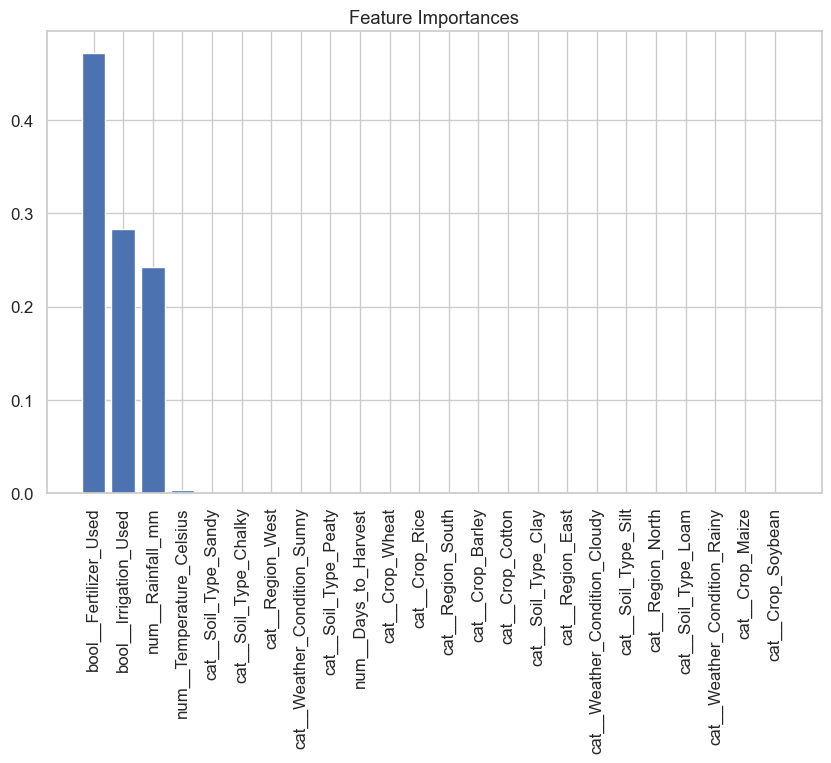

In [ ]:
# Feature importance
model = final_pipeline.named_steps['model']  # XGBRegressor inside pipeline
feature_names = final_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = model.feature_importances_

# Plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Feature Importances")
plt.show()

In [ ]:
import joblib

# Save
joblib.dump(final_pipeline, "final_pipeline.pkl")




['final_pipeline.pkl']

In [ ]:
# Load
loaded_pipeline = joblib.load("final_pipeline.pkl")


In [ ]:
new_data = pd.DataFrame({
    'Region': ['West'],
    'Soil_Type': ['Sandy'],
    'Crop': ['Cotton'],
    'Rainfall_mm': [897.077239],
    'Temperature_Celsius': [27.676966],
    'Fertilizer_Used': [False],
    'Irrigation_Used': [True],
    'Weather_Condition': ['Cloudy'],
    'Days_to_Harvest': [122]
})
# Predict on new data (raw dataframe)
preds = loaded_pipeline.predict(new_data)
print("Predicted Yield (tons per hectare):", preds)

Predicted Yield (tons per hectare): [6.2359624]


In [ ]:
# Predict on X_test
y_pred = loaded_pipeline.predict(X_test)

# Create a small DataFrame to compare actual vs predicted
sample_size = 10
comparison_df = pd.DataFrame({
    'Input': list(X_test.iloc[:sample_size].values),  # if X_test is DataFrame
    'Actual': y_test.iloc[:sample_size].values,
    'Predicted': y_pred[:sample_size]
})

print(comparison_df)



                                               Input    Actual  Predicted
0  [West, Silt, Cotton, 714.854403349598, 23.8758...  3.840988   4.033329
1  [North, Chalky, Cotton, 860.6046720088199, 23....  5.138173   4.756045
2  [North, Sandy, Barley, 802.0819536513903, 24.0...  6.401523   7.194713
3  [West, Chalky, Cotton, 203.61690864475787, 16....  2.658805   2.564344
4  [East, Silt, Rice, 510.528101667994, 18.402902...  2.797703   4.095963
5  [West, Clay, Rice, 932.7185584596132, 32.81576...  7.691631   6.814254
6  [West, Clay, Cotton, 668.8944717790692, 30.558...  6.338488   6.647220
7  [West, Loam, Soybean, 568.5755788466173, 31.83...  5.495826   6.178214
8  [South, Peaty, Cotton, 946.2789457405856, 21.0...  9.076388   7.824197
9  [South, Peaty, Soybean, 406.8835358372541, 28....  3.970273   3.812905


In [ ]:
import xgboost
print("xgboost version:", xgboost.__version__)


xgboost version: 3.0.2
